## GFNMS Upper Heat Content Analysis ##
Using the 4DVars ROMS model from UCSC, Upper Heat Content is calculated as the integral of temperature from 0-100 meters multiplied by the a constant.

Steps:
1. ROMS Data are pulled from the UCSC TDS (THREDDS Data Server)
    1. Data are masked to the boundary of the Monterey Bay National Marine Sanctuary
    2. Converted into discrete depth bins (from sigma coordinates)
2. The __Heat Content__ for the upper 100 meters is calculated
3. Those data are __Spatially Summed__ to for the region to make a time series

__Load the Sanctuary Shape file in first__

In [5]:
# Weird Bug here, but make sure to run this first
import salem
sanctuary_outline= salem.read_shapefile('../data/gfnms_py2/GFNMS_py.shp')
bbox = ((sanctuary_outline['max_y'].max(),sanctuary_outline['min_y'].min()),(sanctuary_outline['max_x'].max(),sanctuary_outline['min_x'].min()))

In [6]:
import sys
sys.path.append("..")
from set_depth import set_depth
import numpy as np
import xarray as xr
from shapely.geometry import Polygon, Point
import scipy.io
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import integrate
import pandas as pd
import datetime as dt
import time, cmocean, scipy.io

Data are accessed through http://oceanmodeling.pmc.ucsc.edu:8080/thredds using `xarray.open_dataset()`

In [7]:
url = 'http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_slevs/fmrc/CCSRA_2016a_Phys_ROMS_Sigma-level_Aggregation_best.ncd'
roms_ds = xr.open_dataset(url)

## Convert the depth coordinates ##
Stretching Information

In [8]:
s_coor_streching_rho = roms_ds['Cs_r'].values # S-coordinate stretching curves at RHO-points
s_coor_streching_w = roms_ds['Cs_w'].values # S-coordinate stretching curves at w-points
vertical_stretching_function = roms_ds['Vstretching'] # vertical terrain following stretching function
vertical_transformation_function = roms_ds['Vtransform'] # vertical terrain following tranformation equation

In [9]:
h = roms_ds['h'] # bathymetry at rho points
h_critical = roms_ds['hc'] # S-coordinate parameter, critical depth
theta_bottom = roms_ds['theta_b'].values # S-coordinate bottom control parameter
theta_surface = roms_ds['theta_s'].values # S-coordinate surface control parameter
zeta = roms_ds['zeta'] # free surface
N_levels=42 # number of levels, note w has 43 levels
zeta = np.squeeze(zeta[0,:,:]) # reduce dimensions to

__Calculate z-depths for rho points__

In [10]:
%%time
igrid=1 # density point grid, for (T,S) use igrid=3, for u and igrid=4 for v # use igrid=5 for w
z_rho = set_depth(vertical_transformation_function, vertical_stretching_function, theta_surface, theta_bottom, h_critical, N_levels, igrid, h, zeta, report=0)

CPU times: user 511 ms, sys: 208 ms, total: 718 ms
Wall time: 4.39 s


__Calculate z-depths for stream functions points__

In [11]:
%%time
igrid=2 # density point grid, for (T,S) use igrid=3, for u and igrid=4 for v # use igrid=5 for w
z_stream = set_depth(vertical_transformation_function, vertical_stretching_function, theta_surface, theta_bottom, h_critical, N_levels, igrid, h, zeta, report=0)

CPU times: user 440 ms, sys: 83.7 ms, total: 524 ms
Wall time: 799 ms


Transpose to the shape we want so z is the third axis<br>
This will now have the shape of as the z data

## Interpolate Temperature to a grid ##
- Take a subset of the ROMS Dataset to work with
- Calculate z-depths with the stretching functions
- At each point interpolate to the nearest z-depth bin


There is a lot going on here, but the idea is to replace the `eta_rho` and `xi_rho` index based dimension with the latitudes and longitudes coordinates, since xarray can handle these natively

In [12]:
roms_ds = xr.open_dataset(url)
roms_temp = roms_ds['temp']
roms_temp_latitude = roms_temp['lat_rho'].values[:,0]
roms_temp_longitude = roms_temp['lon_rho'].values[0,:]
roms_temp = roms_temp.assign_coords({"eta_rho":roms_temp_latitude, "xi_rho":roms_temp_longitude})
roms_temp = roms_temp.rename({"eta_rho":"latitude", "xi_rho":"longitude"})
roms_temp = roms_temp.drop('lat_rho', errors='ignore')
roms_temp = roms_temp.drop('lon_rho', errors='ignore')
roms_temp = roms_temp.drop('time_run', errors='ignore')
roms_temp = roms_temp.transpose('time','latitude','longitude','s_rho')
roms_temp['z_rho'] = (('latitude','longitude','s_rho'),z_rho) # Add the depth values back to the Dataset

In [13]:
def calculate_upper_heat_content(temperature, upper_depth=-100 ):
    """ 
    Calculate upper ocean heat content from ROMS
    
    Calculate the upper ocean heat (J/m^2) content from the CA ROMS model output
    Density is assumed constant at 1025 kg/m^3
    specific heat is 3850 J/(kg C)
    Args:
        temperature: xarray dataset with dimensions (latitude,longitude,s_sho) 
        z_rho: array mapping sigma depth bins to depths in meters with dimensions (latitude,longitude,s_sho) 
        upper_depth: depth to integrate to from the surface, values below the surface are negative

    Returns:
        upper_heat_content: array of upper heat content values in the shape of the temperature input dimensions (latitude, longitude)
        upper_heat_content_b_bins: array of the number of depth bins used for integrated upper heat content in the shape of the temperature input dimensions (latitude, longitude)
    """
    z_rho = temperature.z_rho.values
    cp = 3850
    density = 1025
    
    if len(z_rho.shape) == 1:
        '''Calculating at single point'''
        upper_heat_content = np.zeros(shape=(1))
        upper_heat_content_n_bins = np.zeros(shape=(1))
        roms_temperature_flattened = temperature.values.reshape(-1, temperature.shape[-1])
        
    else:
        upper_heat_content = np.zeros(shape=(z_rho.shape[0]*z_rho.shape[1]))
        upper_heat_content_n_bins = np.zeros(shape=(z_rho.shape[0]*z_rho.shape[1]))
        roms_temperature_flattened = temperature.values.reshape(-1, temperature.shape[-1])
        
    for i, grid_point in enumerate(z_rho.reshape(-1, z_rho.shape[-1])):
        #Find index of depth less than 100 meters
        upper_ix = np.where(grid_point >= upper_depth)[0]
        # Integrate
        if not upper_ix.size == 0:
            integrated_temp = integrate.simps(roms_temperature_flattened[i,upper_ix], grid_point[upper_ix])
            upper_heat_content[i] = density * cp * integrated_temp
            upper_heat_content_n_bins[i] = len(upper_ix)
            
        else:
            upper_heat_content[i] = np.nan
            upper_heat_content_n_bins[i] = np.nan
    
    if len(z_rho.shape) == 1:
        return upper_heat_content, upper_heat_content_n_bins
    
    else:
        upper_heat_content = upper_heat_content.reshape(z_rho.shape[:2])
        upper_heat_content_n_bins = upper_heat_content_n_bins.reshape(z_rho.shape[:2])
        return upper_heat_content, upper_heat_content_n_bins

## Download the GFNMS Data

This is pretty slow still ~30 mintues because the integration needs to be looped and the data has to checked up at each timestep

In [16]:
%%time
gfnms_temp = roms_temp.sel(latitude=slice(bbox[0][1], bbox[0][0]), longitude=slice(bbox[1][1], bbox[1][0]))
gfnms_heat_content = np.zeros(shape=gfnms_temp[:,:,:,0].shape)
for i in range(len(gfnms_heat_content)):
    if i == 0:
        start_time = time.time()
        
    upper_heat_content, upper_heat_content_n_bins = calculate_upper_heat_content(gfnms_temp.isel(time=i), upper_depth=-100)
    gfnms_heat_content[i,:,:] = upper_heat_content
    if i%100 == 0:
        print(i,round(time.time()-start_time,1),'s')
        start_time = time.time()

/Users/patrick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater_equal


0 0.3 s
100 44.8 s
200 42.6 s
300 44.9 s
400 46.1 s
500 47.8 s
600 50.7 s
700 41.5 s
800 40.0 s
900 44.2 s
1000 41.9 s
1100 47.4 s
1200 40.1 s
1300 44.3 s
1400 44.8 s
1500 38.3 s
1600 38.2 s
1700 44.6 s
1800 52.8 s
1900 40.6 s
2000 49.5 s
2100 42.8 s
2200 58.8 s
2300 55.3 s
2400 70.7 s
2500 74.5 s
2600 75.5 s
2700 75.6 s
2800 77.5 s
2900 83.6 s
3000 72.1 s
3100 73.9 s
3200 74.0 s
CPU times: user 1min 12s, sys: 6.49 s, total: 1min 19s
Wall time: 29min 4s


__Now lets create an xarray dataset and use that to save the data as a netcdf file__

For operation, the `time` dimension should be unlimited, so data can be written to the file

In [17]:
data = gfnms_heat_content
time = gfnms_temp.time.values
longitude = gfnms_temp.longitude.values
latitude = gfnms_temp.latitude.values
dims = ['time', 'lat', 'lon']
ds = xr.Dataset({'heat_content_100_meters': (dims, gfnms_heat_content)},
                coords={"time":time,
                        "lon": longitude,
                        "lat": latitude,
                        })
ds.attrs['title'] = "GFNMS Upper Ocean Heat Content - 0-100 meters"
ds.attrs['notes'] = "Created on "+dt.datetime.today().strftime("%Y-%m-%d") + " by pdaniel"

In [18]:
fname = "../data/gfnms_upper_heat_content.nc"
ds.to_netcdf(path=fname)

__Push to pandas and save a csv for posterity__

## Extract time series for the GFNMS ##

Upwelling: April-June<br>
Relaxation: July-September<br>
Storm Season: December-February

In [19]:
ds = xr.open_dataset('../data/gfnms_upper_heat_content.nc')

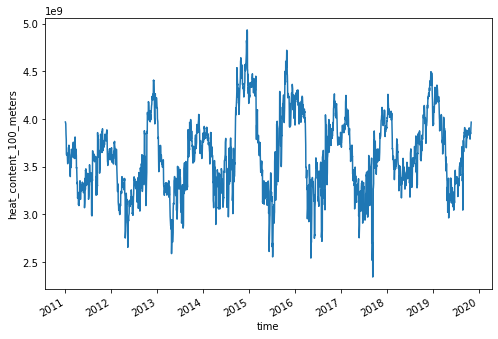

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
gfbms_mask = ds.salem.roi(shape=sanctuary_outline, all_touched=False)
gfbms_mask.mean(dim=['lat','lon'])['heat_content_100_meters'].plot()

Upwelling: April-June<br>
Relaxation: July-September<br>
Storm Season: December-February

In [75]:
def is_upwelling(month):
    return (month >= 3) & (month <= 6)

def is_relaxation(month):
    return (month >= 7) & (month <= 10)

def is_storm(month):
    return (month >= 11) | (month <=2)

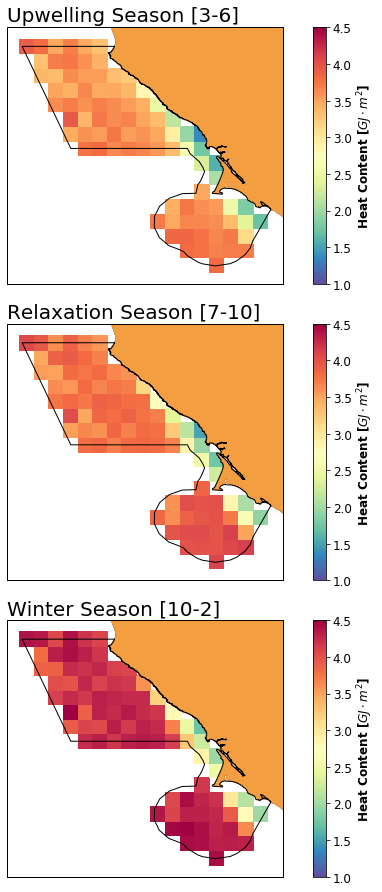

In [121]:
fig, axes = plt.subplots(3, subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(8.5,12.5)

# Upwelling
im = (gfbms_mask.sel(time=is_upwelling(gfbms_mask['time.month']))['heat_content_100_meters'].mean(dim=['time'])/1E9).plot.pcolormesh(
        ax=axes[0], cmap='Spectral_r',
        vmin=1,vmax=4.5,
        add_colorbar=False)

cb = plt.colorbar(im,ax=axes[0])
cb.set_label(label='Heat Content [$GJ \cdot m^{2}$]', size='large', weight='bold')
cb.ax.tick_params(labelsize='large')


# Relaxation
im = (gfbms_mask.sel(time=is_relaxation(gfbms_mask['time.month']))['heat_content_100_meters'].mean(dim=['time'])/1E9).plot.pcolormesh(
        ax=axes[1], cmap='Spectral_r',
        vmin=1,vmax=4.5,
        add_colorbar=False)
cb = plt.colorbar(im,ax=axes[1])
cb.set_label(label='Heat Content [$GJ \cdot m^{2}$]', size='large', weight='bold')
cb.ax.tick_params(labelsize='large')

# Storm Season
im = (gfbms_mask.sel(time=is_storm(gfbms_mask['time.month']))['heat_content_100_meters'].mean(dim=['time'])/1E9).plot.pcolormesh(
        ax=axes[2], cmap='Spectral_r',
        vmin=1,vmax=4.5,
        add_colorbar=False)

cb = plt.colorbar(im,ax=axes[2])
cb.set_label(label='Heat Content [$GJ \cdot m^{2}$]', size='large', weight='bold')
cb.ax.tick_params(labelsize='large')

for ax in axes:
    sanctuary_outline.plot(ax=ax, facecolor='None', edgecolor='k',zorder=10)
    ax.coastlines('10m')
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='#f49e42'))

for ax, title in zip(axes.flat, ['Upwelling Season [3-6]','Relaxation Season [7-10]','Winter Season [10-2]']):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.set_title(title, size=20,loc='left')
    ax.set_xlabel('')

plt.tight_layout()

# plt.savefig('gfnms_seasonal_mean_heat_content.png',dpi=300, bbox_inches='tight', pad_inches=.25)

In [110]:
gfbms_mask.sel(time=is_storm(gfbms_mask['time.month']))['heat_content_100_meters'].mean(dim=['time']).max()

<xarray.DataArray 'heat_content_100_meters' ()>
array(4.49831737e+09)

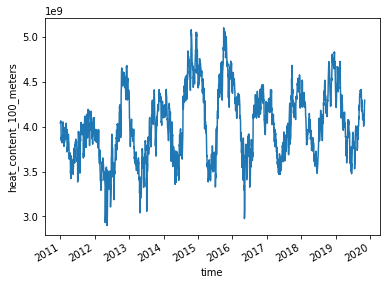

In [262]:
mnbms_mask_touched = ds.salem.roi(shape=offshore, all_touched=True)
mnbms_mask_touched.mean(dim=['lat','lon'])['heat_content_100_meters'].plot()

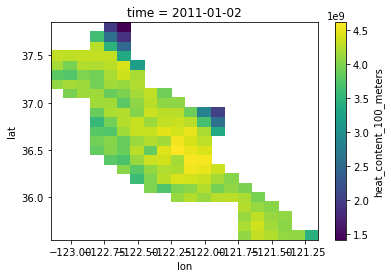

In [250]:
ds.salem.roi(shape=sanctuary_outline[1:], all_touched=True).isel(time=0)['heat_content_100_meters'].plot()